***
<span style="color:#008385">
    
<font size="2.5">
    
Enoch Catuncan - Real-Time ASL Alphabet Recognition<br><p>

</font>
    
<font size="+4.3">
    
**D3 - Query Answering Machine**
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']= 100 # set the resolution to x dpi
import os
import skimage
from skimage import io
from tqdm import tqdm

In [2]:
def load_images(path='./images_dataset'):
    images = {}
    for letter_file in os.listdir(path):
        for fname in tqdm(os.listdir(path + letter_file)):
            product_id = fname[:-4]
            try:
                img = io.imread("{}/{}".format(path + letter_file, fname)) 
                images[product_id] = img
            except:
                print("Error loading ", fname)
    print("Loaded {} images".format(len(images)))
    return images

***
# First QuAM Iteration

As discussed in D2, my first iteration of the QuAM will use the sobel filter and Histogram of Oriented Gradients (HOG) feature descriptor to train a K-Nearest Neighbors (KNN) classifier. This is because, for my task of classification task, the shape of the hand in the images is the most important predictor of the labels and a combination of the sobel filter and HOG emphasizes the edges and shapes in the images.
***

In [20]:
images = load_images(path='./images_dataset_grayscale/')

100%|██████████| 2500/2500 [00:02<00:00, 1243.94it/s]


Loaded 65000 images


In [21]:
df_labels = pd.read_csv("labels_clean.csv")
df_nan = pd.read_csv("labels.csv")
NaN_rows = df_nan[df_nan.isna().any(axis=1)]
for id in NaN_rows['id']:
    images.pop(str(id))

In [22]:
from skimage.transform import resize
from skimage import filters
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

***
I ran out of memory when getting the hog features with 256x256 images so I decided to resize all the images to 128x128 and converting the data type to float16 after the sobel filter.
***

In [23]:
for k in images.keys():
    images[k] = filters.sobel(resize(images[k], (128,128)).astype(np.float16))

In [24]:
hog_features = []
for k in images.keys():
    # Check progress
    if (int(k) % 5000 == 0):
        print("Progress:", k)
    features = hog(images[k], orientations=8, pixels_per_cell=(8, 8),
                      cells_per_block=(3, 3))
    hog_features.append(features)
hog_features = np.array(hog_features)

Progress: 10000
Progress: 15000
Progress: 20000
Progress: 25000
Progress: 30000
Progress: 35000
Progress: 40000
Progress: 45000
Progress: 50000
Progress: 55000
Progress: 60000
Progress: 65000
Progress: 70000


***
For this model, I used a test size of 20% of the total number of images and random state 42 keep the same distribution and accuracy for the same parameters every time. I decided to train multiple KNN classifiers with parameters 5, 10, 15, 20, 25, 30, 35, 40 N neighbors to compare their accuracies and find the n neighbors that gives the best accuracy. I had my range of n neighbors go high since my dataset is large and so it makes sense to have a larger number of neighbors for each data point.
***

In [40]:
x_train, x_test, y_train, y_test = train_test_split(hog_features, df_labels['class'], test_size=0.2, random_state=42)
accuracy = []
for n_neighbors in [5, 10, 15, 20, 25, 30, 35, 40]:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))

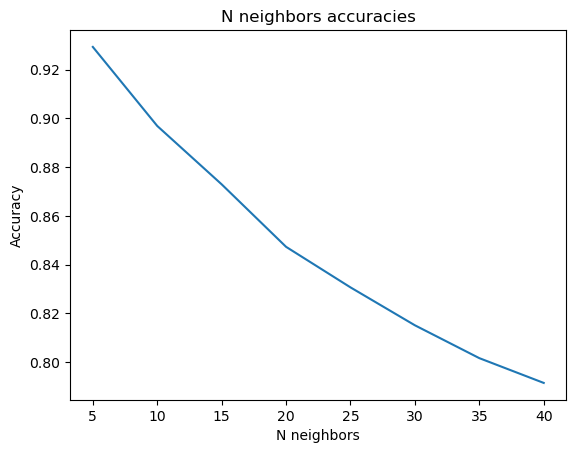

In [41]:
plt.plot([5, 10, 15, 20, 25, 30, 35, 40], accuracy)
plt.title('N neighbors accuracies')
plt.xlabel('N neighbors')
plt.ylabel('Accuracy')
plt.show()

***
The accuracies I got were not what I expected. I had the highest accuracy at 5 N neighbors which I expected would overfit the data and accuracy only decreased as N neighbors decreased. I hypothesized that this was because a lot of the images I had collected myself and online were very similar to each other, as in a lot of the images had the same backgrounds and same places in them where the hand was located and that's why increasing the number of neighbors decreased the accuracy. The data points were likely more bunched up with each other based on these factors of background noise and hand placement and not based on the ASL alphabet hand sign in the image so the more neighbors it took into account, the more neighbors different from its true label were included. To test this hypothesis I used a 5 N neighbors KNN model since it had the highest accuracy and captured a set of 26 images, one for each label, with a different background from the rest of the images used in training that I fed to the model to test its accuracy.
***

In [79]:
x_train, x_test, y_train, y_test = train_test_split(hog_features, df_labels['class'], test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9293809266825996


In [83]:
images_test = []
for fname in tqdm(os.listdir('./images_dataset_test_1/')):
    product_id = fname[:-4]
    try:
        img = io.imread("{}/{}".format('./images_dataset_test_1', fname)) 
        images_test.append(img)
    except:
        print("Error loading ", fname)
print("Loaded {} images".format(len(images_test)))
    
for i, image in enumerate(images_test):
    images_test[i] = filters.sobel(resize(image, (128,128)).astype(np.float16))
    
hog_features_test = []
for image in images_test:
    features = hog(image, orientations=8, pixels_per_cell=(8, 8),
                      cells_per_block=(3, 3))
    hog_features_test.append(features)
hog_features_test = np.array(hog_features_test)

images_test_pred = knn.predict(hog_features_test)
accuracy = accuracy_score([i for i in range(26)], images_test_pred)
print('Accuracy:', accuracy)

100%|██████████| 26/26 [00:00<00:00, 1528.13it/s]


Loaded 26 images
Accuracy: 0.2692307692307692


***
To test it further, I took another 26 images where my hand's position in the image was different from the rest of the images I collected and calculated the accuracy of the model on those.
***

In [84]:
images_test = []
for fname in tqdm(os.listdir('./images_dataset_test_2/')):
    product_id = fname[:-4]
    try:
        img = io.imread("{}/{}".format('./images_dataset_test_2', fname)) 
        images_test.append(img)
    except:
        print("Error loading ", fname)
print("Loaded {} images".format(len(images_test)))
    
for i, image in enumerate(images_test):
    images_test[i] = filters.sobel(resize(image, (128,128)).astype(np.float16))
    
hog_features_test = []
for image in images_test:
    features = hog(image, orientations=8, pixels_per_cell=(8, 8),
                      cells_per_block=(3, 3))
    hog_features_test.append(features)
hog_features_test = np.array(hog_features_test)

images_test_pred = knn.predict(hog_features_test)
accuracy = accuracy_score([i for i in range(26)], images_test_pred)
print('Accuracy:', accuracy)

100%|██████████| 26/26 [00:00<00:00, 1574.44it/s]


Loaded 26 images
Accuracy: 0.038461538461538464


***
The result of the test were accuracies of 0.269 and 0.038 which are very low. This model did not do well at all on truly unseen data, images whose background noise and hand positions are different from the training images, and as such was not fit for my task. For my next QuAM iteration, I then decided to train a CNN model as this model does very well on image classification. It might also handle the background noise well since my dataset is large and the CNN might be able to recognize that the most important feature in the images is the shape of the hand.

***
# Second QuAM Iteration

In [2]:
import time
from time import process_time
from skimage.transform import resize
from skimage import filters
from scipy.signal import convolve2d

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
from keras.utils import np_utils

In [11]:
images = load_images(path='./images_dataset_grayscale/')

100%|██████████| 2500/2500 [00:02<00:00, 1063.61it/s]


Loaded 65000 images


In [12]:
df_labels = pd.read_csv("labels_clean.csv")
df_nan = pd.read_csv("labels.csv")
NaN_rows = df_nan[df_nan.isna().any(axis=1)]
for id in NaN_rows['id']:
    images.pop(str(id))

***
For my CNN classifier, I decided to resize my images to 128x128 to prevent memory errors. Then, after a lot of tinkering with parameters, ended up using the following network for my final QuAM. It has 5 convolution + max pooling layers, using kernel size 3x3 and pool size 2x2, and number of filters starting at 64 and increasing with each consecutive layer. I used 5 convolution + max pooling layers since in class we used 2 for the MNIST digits classification task and my task is more complex. I used a 3x3 kernel for convolution so the CNN would be able to take smaller details, and also a smaller number of filters in the beginning layers to try to discard irrelevant features like the background.
***

In [13]:
for k in images.keys():
    images[k] = resize(images[k], (128,128)).astype(np.float32)

In [32]:
img_shape = (128, 128, 1)

CNN_model = Sequential()



CNN_model.add(Conv2D(64, kernel_size=(3, 3), input_shape=img_shape))
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))



CNN_model.add(Conv2D(128, kernel_size=(3, 3)))
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))



CNN_model.add(Conv2D(256, kernel_size=(3, 3)))
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))



CNN_model.add(Conv2D(512, kernel_size=(3, 3)))
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))



CNN_model.add(Conv2D(512, kernel_size=(3, 3)))
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(Dropout(0.5))
CNN_model.add(Flatten())



CNN_model.add(Dense(128))
CNN_model.add(Activation('relu'))



CNN_model.add(Dense(26))
CNN_model.add(Activation('softmax'))

In [33]:
CNN_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])

In [24]:
X = np.array(list(images.values()))

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, df_labels['class'], test_size=0.2, random_state=42)
class_names = [str(d) for d in range(26)]
X_train = X_train.reshape(X_train.shape[0], * img_shape)
X_test = X_test.reshape(X_test.shape[0], * img_shape)

Y_train = np_utils.to_categorical(y_train, 26)
Y_test = np_utils.to_categorical(y_test, 26)

In [27]:
n_data_train = int(0.3 * X_train.shape[0])
n_data_test = int(0.3 * X_test.shape[0])

***
I decided on using 20 epochs as the CNN model usually plateaus right before that.
***

In [34]:
batch_size = 128
epochs = 20

start_time = time.process_time()
        
training = CNN_model.fit(X_train[0:n_data_train], Y_train[0:n_data_train], 
                         batch_size=batch_size, 
                         epochs=epochs, 
                         validation_data=(X_test[0:n_data_test], 
                                          Y_test[0:n_data_test]),
                         verbose=2)
    
print('\n\nTraining time: {:.3f} sec\n'.format(time.process_time() - start_time))

score = CNN_model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
122/122 - 189s - loss: 3.2514 - accuracy: 0.0419 - val_loss: 3.2207 - val_accuracy: 0.0660 - 189s/epoch - 2s/step
Epoch 2/20
122/122 - 192s - loss: 2.8873 - accuracy: 0.1598 - val_loss: 2.2254 - val_accuracy: 0.3480 - 192s/epoch - 2s/step
Epoch 3/20
122/122 - 192s - loss: 1.8267 - accuracy: 0.4450 - val_loss: 1.3441 - val_accuracy: 0.6086 - 192s/epoch - 2s/step
Epoch 4/20
122/122 - 191s - loss: 1.2024 - accuracy: 0.6291 - val_loss: 0.9571 - val_accuracy: 0.7052 - 191s/epoch - 2s/step
Epoch 5/20
122/122 - 190s - loss: 0.8528 - accuracy: 0.7334 - val_loss: 0.7107 - val_accuracy: 0.7905 - 190s/epoch - 2s/step
Epoch 6/20
122/122 - 191s - loss: 0.6344 - accuracy: 0.7978 - val_loss: 0.5595 - val_accuracy: 0.8276 - 191s/epoch - 2s/step
Epoch 7/20
122/122 - 194s - loss: 0.4991 - accuracy: 0.8373 - val_loss: 0.5636 - val_accuracy: 0.8329 - 194s/epoch - 2s/step
Epoch 8/20
122/122 - 193s - loss: 0.3947 - accuracy: 0.8676 - val_loss: 0.4265 - val_accuracy: 0.8697 - 193s/epoch - 2s/step


***
The results of my CNN classifier were relatively high with 0.965 training accuracy and 0.925 test accuracy.
***

In [37]:
CNN_model.save('./CNN_model')

INFO:tensorflow:Assets written to: ./CNN_model\assets


INFO:tensorflow:Assets written to: ./CNN_model\assets


In [35]:
def show_learning_curves(learning_evolution, title=''):
    print('Stored information:', [h for h in learning_evolution.history.keys()])

    plt.plot(learning_evolution.history['accuracy'])
    .0

    if 'val_accuracy' in learning_evolution.history:
        plt.plot(learning_evolution.history['val_accuracy'])

    plt.title(title + 'Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(learning_evolution.history['loss'])
    
    if 'val_accuracy' in learning_evolution.history:
        plt.plot(learning_evolution.history['val_loss'])

    plt.title(title + 'Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Stored information: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


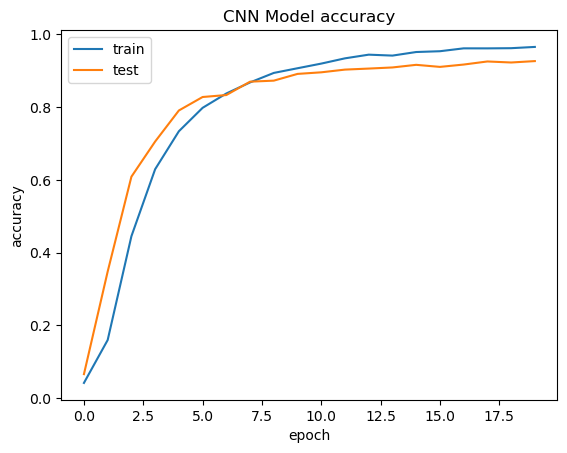

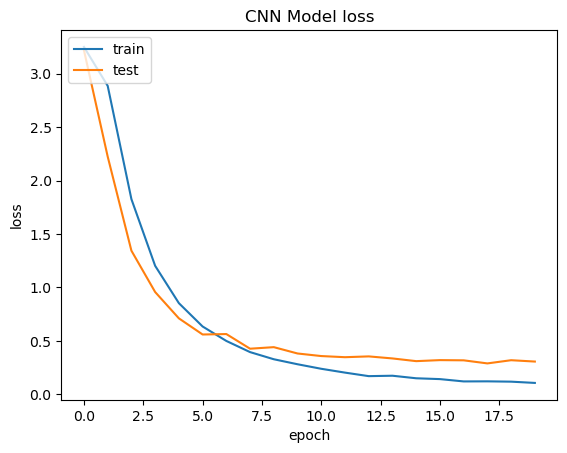

In [36]:
show_learning_curves(training, 'CNN ')

***
As can be seen, the CNN model followed the typical learning curve. My model ended up plateauing at around 10 to 12 epochs where it reached its near highest train and test scores.
***

406/406 [==============================] - 44s 108ms/step


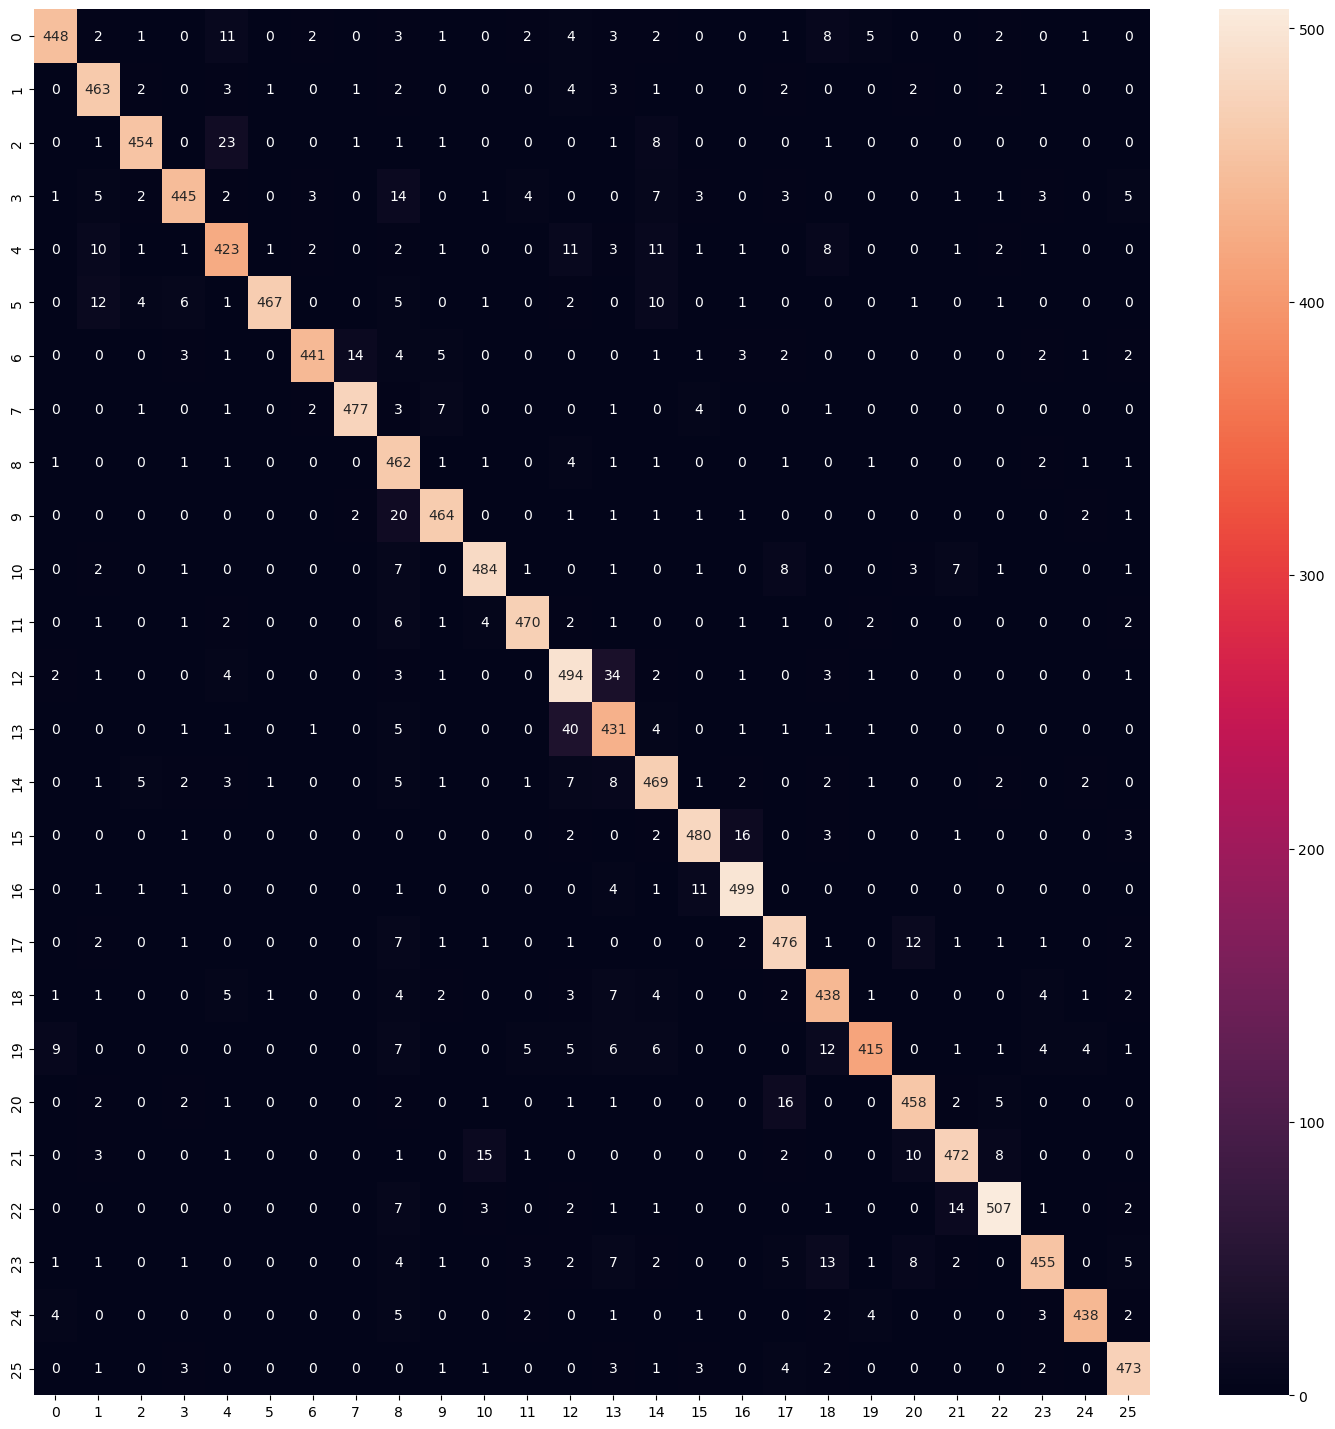

In [41]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

Y_prediction = CNN_model.predict(X_test)

Y_pred_classes = np.argmax(Y_prediction, axis = 1)

Y_true = np.argmax(Y_test, axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plt.figure(figsize=(18,18))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

***
From the confusion matrix, we can see that the biggest issue is confusion between labels 12 and 13 which makes sense as these are letters m and n, and these two letters look very similar in the ASL alphabet. Other than that, it seemed that the model did very well, however, I still needed to validate with the same images I used to validate the KNN model. 
***

In [38]:
images_test = []
for fname in tqdm(os.listdir('./images_dataset_test_1/')):
    try:
        img = io.imread("{}/{}".format('./images_dataset_test_1', fname)) 
        images_test.append(img)
    except:
        print("Error loading ", fname)
print("Loaded {} images".format(len(images_test)))

for i, image in enumerate(images_test):
    #images_test[i] = rescale_intensity(convolve2d(filters.gaussian(resize(image, (64,64))), sharpening, mode='same'), in_range=(0, 1)).astype(np.float32)
    images_test[i] = resize(image, (128,128)).astype(np.float32)

images_test_x = np.array(images_test)

#images_test_x = images_test_x.reshape(images_test_x.shape[0], * img_shape)
    
Y_pred_probs   = CNN_model.predict(images_test_x)
Y_pred_classes = np.argmax(Y_pred_probs,axis=1)

print('{} Predicted class (with probability) {}\n'.format('*'*5, '*'*5))
for i in range(26):
    true_label = i
    predicted_class = Y_pred_classes[i]
    prediction_prob = Y_pred_probs[i, predicted_class]
    print('Input [class {}] -> Output: {} ({:.2f})\n'.format(true_label, 
                                                             predicted_class,
                                                             prediction_prob))

100%|██████████| 26/26 [00:00<00:00, 711.70it/s]


Loaded 26 images
1/1 [==============================] - 0s 244ms/step
***** Predicted class (with probability) *****

Input [class 0] -> Output: 0 (0.93)

Input [class 1] -> Output: 1 (0.99)

Input [class 2] -> Output: 8 (0.87)

Input [class 3] -> Output: 21 (0.81)

Input [class 4] -> Output: 14 (0.46)

Input [class 5] -> Output: 5 (0.67)

Input [class 6] -> Output: 9 (0.83)

Input [class 7] -> Output: 9 (0.99)

Input [class 8] -> Output: 8 (1.00)

Input [class 9] -> Output: 15 (0.87)

Input [class 10] -> Output: 8 (0.89)

Input [class 11] -> Output: 8 (0.98)

Input [class 12] -> Output: 8 (0.82)

Input [class 13] -> Output: 8 (0.98)

Input [class 14] -> Output: 8 (0.90)

Input [class 15] -> Output: 15 (0.45)

Input [class 16] -> Output: 15 (0.70)

Input [class 17] -> Output: 21 (0.67)

Input [class 18] -> Output: 23 (0.93)

Input [class 19] -> Output: 13 (0.50)

Input [class 20] -> Output: 21 (0.58)

Input [class 21] -> Output: 22 (1.00)

Input [class 22] -> Output: 22 (1.00)

Input [

***
As we can see, the model does not do very well with these images as they have a lot of background noise; only 6 images were labelled correctly. Take for example the following image.

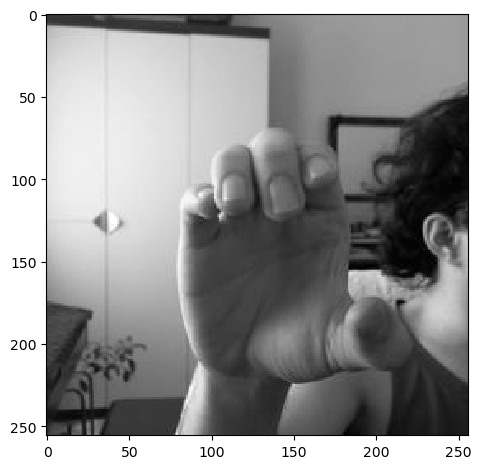

In [44]:
io.imshow(io.imread(r'.\images_dataset_test_1\02.jpg'))

There is a lot of irrelevant features that the CNN likely takes into account such as me, the wardrobe and the shadows, which leads the model into making a wrong prediction. This seems to be a big weakness of my final QuAM and testing with my real-time image recognition interface showed the same thing. When the background was plain and uniform, it could label the ASL alphabets accurately but when the background is like the image above, it gets very confused. To improve my QuAM, I would likely have to update my dataset to include images with different complex backgrounds to train the CNN model to disregard these irrelevant features.
***